<a href="https://colab.research.google.com/github/halisson-gomides/IESB/blob/main/deep_learning/trabalho_final/trabalhofinaldeeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> <font color="red"> ===== Trabalho Deep Learning - Classificação de Áudio =====</font></h1>

<br>
<h5 align="right">Brasília, dezembro de 2022</h5>
<br>
<b align="center"> Professor: Mateus Mendelson</b>
<br><br>
<b align="center"> Alunos:</b><br>
<b align="center">Halisson Souza Gomides </b><br>
<b align="center"> Lorena Vaz</b><br>
<b align="center"> Roberto Rodrigues Adrego</b>
<br><br>

In [ ]:
import os
import pathlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display as ld
from IPython.display import Audio
from tqdm import tqdm
import tensorflow
#print('Versão Tensorflow: ', tensorflow.__version__)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

#### Verifica a disponibilidade de GPU

In [ ]:
if tensorflow.test.gpu_device_name(): 
    print('GPU Device:{}'.format(tensorflow.test.gpu_device_name()))
else:
   print("Sem GPU, é o que tem pra hoje!")

GPU Device:/device:GPU:0


####Sobre o conjunto de dados
<br>Este conjunto de dados contém 8732 trechos de som rotulados (<=4s) de sons urbanos de 10 classes: 
<br>ar condicionado, buzina de carro, crinaça brincando, latido de cachorro, >perfuração, motor em marcha lenta, tiro de arma, britadeira, sirene e música de rua. <br>As classes são extraídas da taxonomia sonora urbana. 
##### Informações sobre o dataset poderão ser consultadas no link a seguir
https://urbansounddataset.weebly.com/urbansound8k.html

#### Baixando o dataset

In [ ]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O Urban8K.tgz

--2022-12-10 12:53:01--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘Urban8K.tgz’

Urban8K.tgz         100%[===================>]   5.61G  19.2MB/s    in 5m 7s   

2022-12-10 12:58:10 (18.7 MB/s) - ‘Urban8K.tgz’ saved [6023741708/6023741708]



#### Descompacta o arquivo

In [ ]:
!tar -xzf Urban8K.tgz

In [ ]:
#!rm Urban8K.tgz  #renomeia o arquivo original

#### Carrega o arquivo

In [ ]:
df1 = pd.read_csv('/content/UrbanSound8K/metadata/UrbanSound8K.csv')
df1

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


#### Cria as listas para armazenar os dados

In [ ]:
fsID = []
classID = []
occurID = []
sliceID = []
caminho_arquivo = []

for root, dirs, files in os.walk('/content/UrbanSound8K/audio'):  # o walk caminha por todos os arquivos de todos os diretórios
  #print(root)
  #print(dirs)
  #print(files)
  for file in files:
    try: # crio o bloco com o  try para evitar que durante a leitura ela seja parada por algum erro ou leitura de algum arquivo que possa estar em outra extensão, quebrando por "-""
      #print(file.split('-'))
      fs = int(file.split('-')[0]) #fs_ID
      class_ = int(file.split('-')[1]) #class
      occur = int(file.split('-')[2]) #occur
      slice_ = file.split('-')[3] #slice
      slice_ = int(slice_.split('.')[0]) #remove o .wav
      #print(fs)

      #Adiciona em listas
      fsID.append(fs)
      classID.append(class_)
      occurID.append(occur)
      sliceID.append(slice_)

      caminho_arquivo.append((root, file))
    except ValueError:
      continue

In [ ]:
#print(occurID)
#print(fsID)
print(caminho_arquivo)

[('/content/UrbanSound8K/audio/fold5', '72259-1-6-0.wav'), ('/content/UrbanSound8K/audio/fold5', '80806-2-0-3.wav'), ('/content/UrbanSound8K/audio/fold5', '72259-1-10-3.wav'), ('/content/UrbanSound8K/audio/fold5', '104998-7-16-10.wav'), ('/content/UrbanSound8K/audio/fold5', '104998-7-0-5.wav'), ('/content/UrbanSound8K/audio/fold5', '157648-8-0-0.wav'), ('/content/UrbanSound8K/audio/fold5', '23219-5-0-7.wav'), ('/content/UrbanSound8K/audio/fold5', '104998-7-17-8.wav'), ('/content/UrbanSound8K/audio/fold5', '155243-9-0-42.wav'), ('/content/UrbanSound8K/audio/fold5', '203913-8-1-3.wav'), ('/content/UrbanSound8K/audio/fold5', '39533-4-0-0.wav'), ('/content/UrbanSound8K/audio/fold5', '31150-2-0-17.wav'), ('/content/UrbanSound8K/audio/fold5', '72259-1-8-0.wav'), ('/content/UrbanSound8K/audio/fold5', '171388-9-0-202.wav'), ('/content/UrbanSound8K/audio/fold5', '72259-1-9-2.wav'), ('/content/UrbanSound8K/audio/fold5', '43787-3-2-0.wav'), ('/content/UrbanSound8K/audio/fold5', '72259-1-10-1.wav'

#### Classes
<br>A numeric identifier of the sound class:
<br>0 = air_conditioner
<br>1 = car_horn
<br>2 = children_playing
<br>3 = dog_bark
<br>4 = drilling
<br>5 = engine_idling
<br>6 = gun_shot
<br>7 = jackhammer
<br>8 = siren
<br>9 = street_music

Informações da identificação da classe foram retiradas no link abaixo
<br>https://urbansounddataset.weebly.com/urbansound8k.html


#### Transforma a lista em dicionário

In [ ]:
lista_sons = ['ar_condicionado', 'buzina_carro', 'crianca_brincando', 'latido_cachorro', 'perfuracao', 'motor_em_marcha_lenta', 'tiro_arma', 'britadeira', 'sirene', 'musica_de_rua']
dict_sons = {em[0]:em[1] for em in enumerate(lista_sons)} #retorna um objeto iterável.

In [ ]:
dict_sons

{0: 'ar_condicionado',
 1: 'buzina_carro',
 2: 'crianca_brincando',
 3: 'latido_cachorro',
 4: 'perfuracao',
 5: 'motor_em_marcha_lenta',
 6: 'tiro_arma',
 7: 'britadeira',
 8: 'sirene',
 9: 'musica_de_rua'}

#### Cria outro dataframe em matriz transposta

In [ ]:
df = pd.DataFrame([fsID, classID, occurID, sliceID, caminho_arquivo]).T
df

,0,1,2,3,4
0,72259,1,6,0,"(/content/UrbanSound8K/audio/fold5, 72259-1-6-..."
1,80806,2,0,3,"(/content/UrbanSound8K/audio/fold5, 80806-2-0-..."
2,72259,1,10,3,"(/content/UrbanSound8K/audio/fold5, 72259-1-10..."
3,104998,7,16,10,"(/content/UrbanSound8K/audio/fold5, 104998-7-1..."
4,104998,7,0,5,"(/content/UrbanSound8K/audio/fold5, 104998-7-0..."
...,...,...,...,...,...
8727,74364,8,1,7,"(/content/UrbanSound8K/audio/fold10, 74364-8-1..."
8728,188497,2,0,2,"(/content/UrbanSound8K/audio/fold10, 188497-2-..."
8729,159742,8,0,0,"(/content/UrbanSound8K/audio/fold10, 159742-8-..."
8730,189982,0,0,17,"(/content/UrbanSound8K/audio/fold10, 189982-0-..."


#### Nomeia as colunas do dataframe df

In [ ]:
df.columns = ['fsID', 'classID', 'occurID', 'sliceID', 'caminho']
df

,fsID,classID,occurID,sliceID,caminho
0,72259,1,6,0,"(/content/UrbanSound8K/audio/fold5, 72259-1-6-..."
1,80806,2,0,3,"(/content/UrbanSound8K/audio/fold5, 80806-2-0-..."
2,72259,1,10,3,"(/content/UrbanSound8K/audio/fold5, 72259-1-10..."
3,104998,7,16,10,"(/content/UrbanSound8K/audio/fold5, 104998-7-1..."
4,104998,7,0,5,"(/content/UrbanSound8K/audio/fold5, 104998-7-0..."
...,...,...,...,...,...
8727,74364,8,1,7,"(/content/UrbanSound8K/audio/fold10, 74364-8-1..."
8728,188497,2,0,2,"(/content/UrbanSound8K/audio/fold10, 188497-2-..."
8729,159742,8,0,0,"(/content/UrbanSound8K/audio/fold10, 159742-8-..."
8730,189982,0,0,17,"(/content/UrbanSound8K/audio/fold10, 189982-0-..."


In [ ]:
df['caminho'] 

0       (/content/UrbanSound8K/audio/fold5, 72259-1-6-...
1       (/content/UrbanSound8K/audio/fold5, 80806-2-0-...
2       (/content/UrbanSound8K/audio/fold5, 72259-1-10...
3       (/content/UrbanSound8K/audio/fold5, 104998-7-1...
4       (/content/UrbanSound8K/audio/fold5, 104998-7-0...
                              ...                        
8727    (/content/UrbanSound8K/audio/fold10, 74364-8-1...
8728    (/content/UrbanSound8K/audio/fold10, 188497-2-...
8729    (/content/UrbanSound8K/audio/fold10, 159742-8-...
8730    (/content/UrbanSound8K/audio/fold10, 189982-0-...
8731    (/content/UrbanSound8K/audio/fold10, 73524-0-0...
Name: caminho, Length: 8732, dtype: object

In [ ]:
df['classID'] 

0       1
1       2
2       1
3       7
4       7
       ..
8727    8
8728    2
8729    8
8730    0
8731    0
Name: classID, Length: 8732, dtype: object

In [ ]:
df['classID'].map(dict_sons)

0            buzina_carro
1       crianca_brincando
2            buzina_carro
3              britadeira
4              britadeira
              ...        
8727               sirene
8728    crianca_brincando
8729               sirene
8730      ar_condicionado
8731      ar_condicionado
Name: classID, Length: 8732, dtype: object

#### Mapeia o Id da classe e o nome da classe e concatena o caminho para ficar o caminho completo

In [ ]:
df['classID'] = df['classID'].map(dict_sons)
#df['classID']

df['caminho'] = df['caminho'].apply(lambda x: x[0] + '/' + x[1]) #concatena em tempo de execução,onde x[0] é a primeira parte e x[1] é o nome do arquivo
df

,fsID,classID,occurID,sliceID,caminho
0,72259,buzina_carro,6,0,/content/UrbanSound8K/audio/fold5/72259-1-6-0.wav
1,80806,crianca_brincando,0,3,/content/UrbanSound8K/audio/fold5/80806-2-0-3.wav
2,72259,buzina_carro,10,3,/content/UrbanSound8K/audio/fold5/72259-1-10-3...
3,104998,britadeira,16,10,/content/UrbanSound8K/audio/fold5/104998-7-16-...
4,104998,britadeira,0,5,/content/UrbanSound8K/audio/fold5/104998-7-0-5...
...,...,...,...,...,...
8727,74364,sirene,1,7,/content/UrbanSound8K/audio/fold10/74364-8-1-7...
8728,188497,crianca_brincando,0,2,/content/UrbanSound8K/audio/fold10/188497-2-0-...
8729,159742,sirene,0,0,/content/UrbanSound8K/audio/fold10/159742-8-0-...
8730,189982,ar_condicionado,0,17,/content/UrbanSound8K/audio/fold10/189982-0-0-...


In [ ]:
df.describe()
# Existem 8732 áudios diferentes que foram extraído de 188 áudios completos

,fsID,classID,occurID,sliceID,caminho
count,8732,8732,8732,8732,8732
unique,1297,10,69,188,8732
top,24347,crianca_brincando,0,0,/content/UrbanSound8K/audio/fold5/72259-1-6-0.wav
freq,100,1000,6132,2185,1


#### Visualiza a contagem das classes

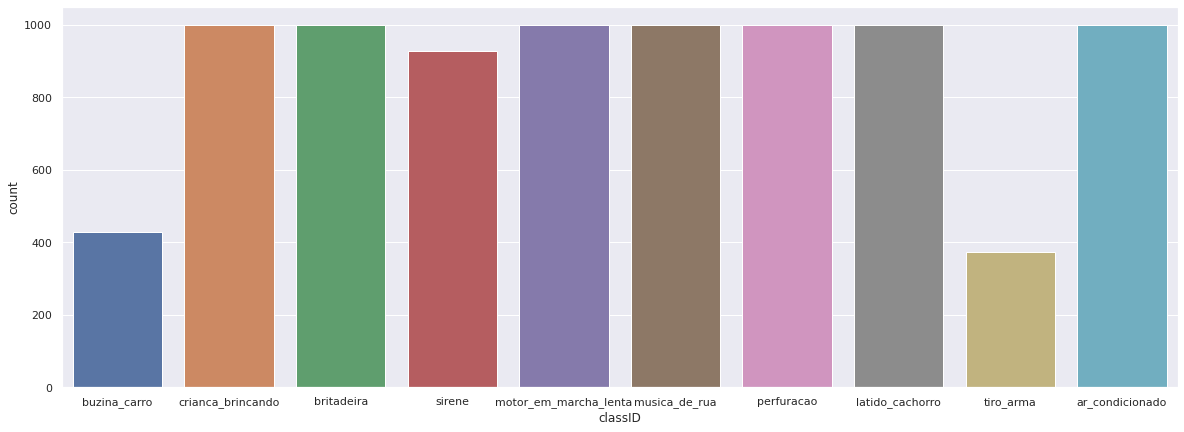

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(df['classID']);

In [ ]:
print(df.shape)

(8732, 5)


#### Pega aleatoriamente um áudio do arquivo para checagem de acordo com o índice informado

In [ ]:
nome_arquivo = df['caminho'].sample().squeeze()
data, sample_rate = librosa.load(nome_arquivo, sr = None) #será carregada a taxa de reamostragem original deo arquivo, e não o  22050 Hz é o valor padrão da reamostragem da biblioteca librosa
print(nome_arquivo)

/content/UrbanSound8K/audio/fold6/135544-6-15-0.wav


In [ ]:
data # arquivo em mono pois se não passar o parametro mono - False ele é True por padrão

array([-0.12418115, -0.11988944, -0.1143595 , ..., -0.03274322,
       -0.03391927, -0.03609157], dtype=float32)

In [ ]:
Audio(data = data, rate = sample_rate) 


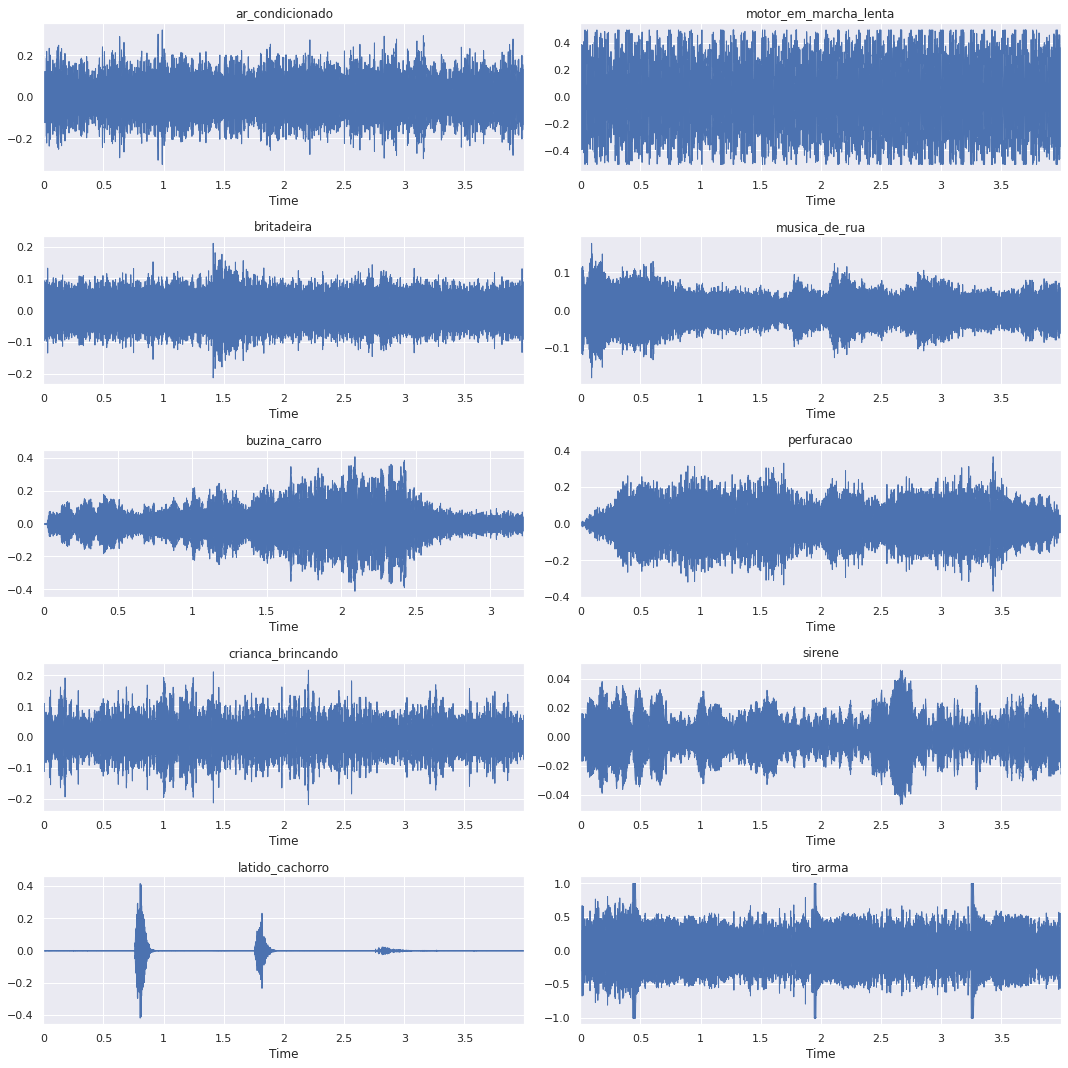

In [ ]:
# Busca algumas amostras do dataset
random_amostras = df.groupby('classID').sample(1) # agrupa os registros de acordo com a classe
amostras_audio, labels = random_amostras['caminho'].tolist(), random_amostras['classID'].tolist() # precisa converter pra lista
#print(random_amostras)
#print(amostras_audio)
rows = 5
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(15,15))
index = 0
# percorrendo o número de linhas e colunas conforme definido
for col in range(cols): 
  for row in range(rows): 
    data, sample_rate = librosa.load(amostras_audio[index], sr = None)
    librosa.display.waveplot(data, sample_rate, ax = ax[row][col])
    ax[row][col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout() #ajusta o layout de forma automática

#### Busca algumas amostras do dataset, uma amostra de cada classe, para visualizar o gráfico de ondas.

#### Espectrograma MFCC

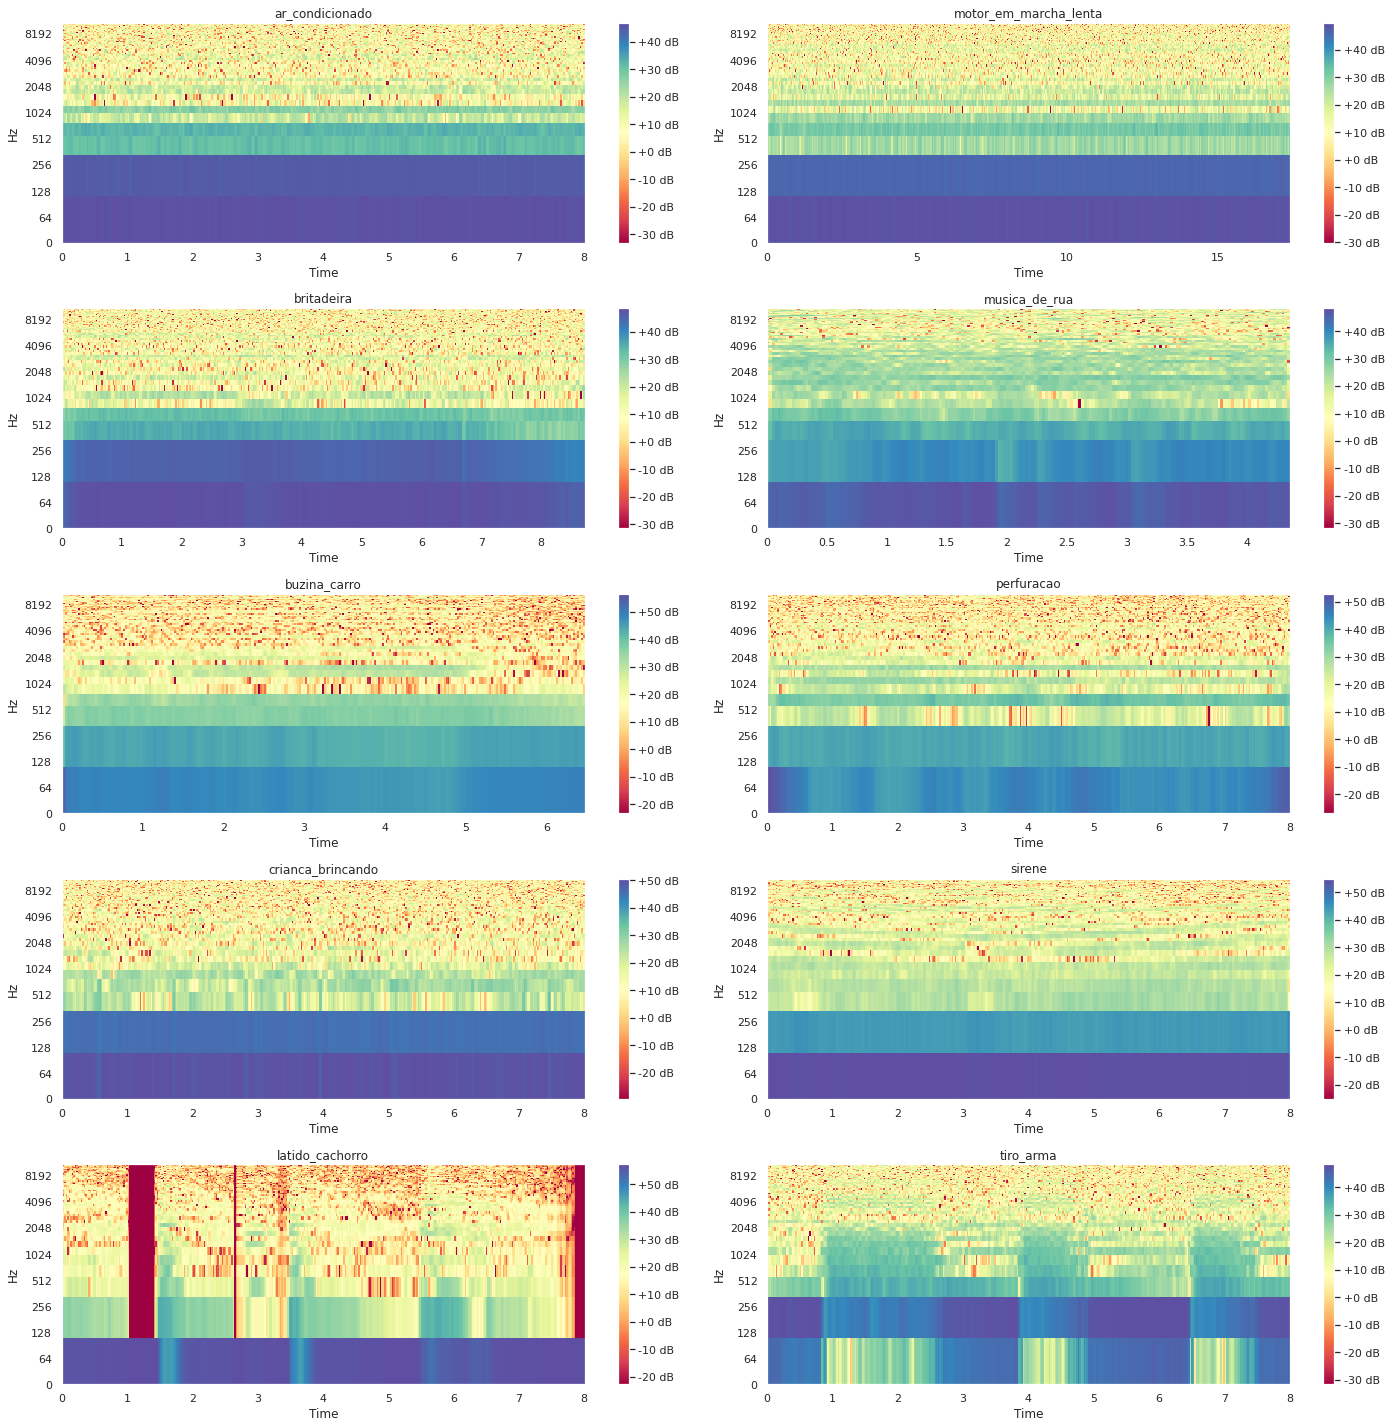

In [ ]:
# Espectrograma MFCC
# Representação padrão para trabalhar com áudio
# Extrai as características para enviar para a rede neural
# Espectogramas é um conjunto de características que foram extraídas do audio, e como são imagens e por esse motivo podem ser enviadas para a rede neural
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(amostras_audio[index], sr = None) # usa a mesma variável amostras_audio e sr = none pois usa a mesma taxa de amostragem dos audios
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=50) # y = as amostras de audio, 50 valores
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs)) # converte para decibeis
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral') #y_axis='log' porque é uma forma mais parecida com a forma que os seres humanos conseguem ouvir
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

####Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset

Coeficiente cepstral de frequência de Mel
<br>Obtém o espectrograma de uma forma mais parecida com a forma que o ouvido humano ouve.

In [ ]:
def extrai_features (caminho):
  data, sample_rate = librosa.load(caminho, sr = None, res_type = 'kaiser_fast') #'kaiser_fast' para carregar mais rápido os arquivos, o kaiser_best 
  mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc=50) # passa os dados , o sample rate , onde n_mfcc nesse caso é de 50 valores (linhas do espctrograma)
  mfcss_features_norm = np.mean(mfccs_features.T, axis = 0) #normaliza os valores
  return mfcss_features_norm

#### Cria uma lista para percorrer os arquivos para adicionar os dados que foram extraídos

In [ ]:
lista_features = []
#percorre cada um dos arquivos, usei o tqdm para mostrar a barrinha de progresso
for caminho in tqdm(df['caminho'].values):
  #print(path)
  data = extrai_features(caminho)
  lista_features.append([data])

100%|██████████| 8732/8732 [04:37<00:00, 31.49it/s]


In [ ]:
len(lista_features)

8732

In [ ]:
np.array(lista_features[0]).shape

(1, 50)

#### Preparação dos dados

In [ ]:
# Converte as features extraídas para visualização com Pandas, mostra as 40 features MFCCs
lista_features_df = pd.DataFrame(lista_features, columns = ['feature'])
lista_features_df

,feature
0,"[-283.04913, 204.42273, -65.82122, 38.548668, ..."
1,"[-187.15514, 153.04971, -78.41642, 73.82303, -..."
2,"[-222.60396, 215.24725, -73.82618, 37.70627, -..."
3,"[-175.13382, 63.332146, -59.997746, 30.711182,..."
4,"[-213.29327, 74.3864, -46.259415, 35.522335, -..."
...,...
8727,"[-429.0498, 129.906, -8.35587, 15.827984, 11.7..."
8728,"[-634.2978, 203.10844, -8.67264, -2.2260683, 9..."
8729,"[-780.95013, 99.81632, 48.475613, 14.276931, 4..."
8730,"[-166.46506, 156.57373, -18.87096, 23.043081, ..."


#### Divisão dos atributos entre as classes e previsores

In [ ]:
# Divide entre atributos classe(class) e atributos previsores(features)
X = np.array(lista_features_df['feature'].tolist())
y = np.array(df['classID'].tolist())

In [ ]:
X.shape

(8732, 50)

In [ ]:
X

array([[-2.8304913e+02,  2.0442273e+02, -6.5821220e+01, ...,
         2.7769704e+00,  2.5709417e+00, -1.7016660e+00],
       [-1.8715514e+02,  1.5304971e+02, -7.8416420e+01, ...,
        -2.7726924e+00, -2.1692104e+00, -7.3575181e-01],
       [-2.2260396e+02,  2.1524725e+02, -7.3826180e+01, ...,
         6.2165165e+00,  2.8652337e+00, -4.4042234e+00],
       ...,
       [-7.8095013e+02,  9.9816322e+01,  4.8475613e+01, ...,
        -2.5606078e-01, -1.5180892e+00, -1.4308926e+00],
       [-1.6646506e+02,  1.5657373e+02, -1.8870960e+01, ...,
         1.4822580e-01,  3.2047594e+00,  1.9016187e+00],
       [-1.7154880e+02,  1.5831625e+02, -1.0291264e+01, ...,
        -4.3946881e+00, -9.7753704e-01, -2.8329778e+00]], dtype=float32)

In [ ]:
y

array(['buzina_carro', 'crianca_brincando', 'buzina_carro', ..., 'sirene',
       'ar_condicionado', 'ar_condicionado'], dtype='<U21')

#### Aplica o Label Encoder pois os atributos da classe são variáveis categóricas

In [ ]:
#Transforma atributos categórios para atributos numéricos
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
#y[0]
y[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

#### Divide o conjunto de dados para treino, teste e validação

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1) # 80% dos dados para treinamento
X_val, X_test, y_val ,y_test  = train_test_split(X_test, y_test, test_size = 0.5, random_state=1) # 20% restante, 50% será para validação e 50% para teste

In [ ]:
X_train.shape ,X_test.shape, X_val.shape

((6985, 50), (874, 50), (873, 50))

In [ ]:
y_train.shape,y_test.shape, y_val.shape

((6985, 10), (874, 10), (873, 10))

#### Adiciona uma dimensão no final para enviar para a rede convolucional, os demais dados são mantidos

In [ ]:
# Adiciona uma dimensão no final para enviar para a rede convolucional, para deixar no padrão que a rede trabalha
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_val = X_val[:,:,np.newaxis]

In [ ]:
X_train.shape

(6985, 50, 1)

#### Criação do modelo

In [ ]:
#Cria o modelo
modelo = Sequential()

#primeira camada
modelo.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1], 1))) # X_train.shape[1] porque é a segunda coluna, as 50 caracteísticas, com o valor 1 que é dimensão adicionada anteriormente
modelo.add(Dropout(0.4)) # para evitar o overfitting, zerando 40% dos neurônios 
modelo.add(MaxPooling1D(pool_size=(4))) #reduz a dimensão

#segunda camada
modelo.add(Conv1D(128, 10, padding='same',)) #128 canais de saida , filtro 10 e o padding(preenchimento) = same que preenche com uma coluna de zeros
modelo.add(Activation('relu'))
modelo.add(Dropout(0.4))
modelo.add(MaxPooling1D(pool_size=(4))) #matriz 4x4

modelo.add(Flatten()) #achata, converte a matriz para um vetor

modelo.add(Dense(units = 64)) #64 neuronios na camada de entrada da rede neural 
modelo.add(Dropout(0.4))
modelo.add(Dense(units = 10)) #tem 10 classes
modelo.add(Activation('softmax')) # essa função gera uma probabilidade, tem 10 classe

#### Compila do modelo

In [ ]:
# compila a estrutura da rede neural
modelo.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam') #optimizer descida do gradiente, metrics = ['accuracy'] (taxa de acerto)
#mostra a estrutura da rede criada
modelo.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 41, 64)            704       
                                                                 
 dropout (Dropout)           (None, 41, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           82048     
                                                                 
 activation (Activation)     (None, 10, 128)           0         
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                        

#### Treinamento do modelo

In [ ]:
#Treina o modelo da rede
num_epochs = 200
num_batch_size = 32 #batchs de 32 em 32 audios

melhor_modelo = ModelCheckpoint(filepath = 'modelos_salvos/classificacao_sons.hdf5', verbose = 1, save_best_only = True) #verbose = 1 para mostrar as mensagens
inicio_treinamento = datetime.now()
history = modelo.fit(X_train, y_train, batch_size = num_batch_size, epochs = num_epochs, validation_data = (X_val, y_val) #validation_data para avaliar os resultados parciais a cada época
                     ,callbacks = [melhor_modelo], verbose = 1)
duracao = datetime.now() - inicio_treinamento
print('Duração do treinamento: ', duracao)

Epoch 1/200
219/219 [==============================] - ETA: 0s - loss: 3.2257 - accuracy: 0.2673
Epoch 1: val_loss improved from inf to 1.82492, saving model to modelos_salvos/classificacao_sons.hdf5
219/219 [==============================] - 12s 6ms/step - loss: 3.2257 - accuracy: 0.2673 - val_loss: 1.8249 - val_accuracy: 0.4570
Epoch 2/200
209/219 [===========================>..] - ETA: 0s - loss: 1.7169 - accuracy: 0.3955
Epoch 2: val_loss improved from 1.82492 to 1.53280, saving model to modelos_salvos/classificacao_sons.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 1.7147 - accuracy: 0.3963 - val_loss: 1.5328 - val_accuracy: 0.5704
Epoch 3/200
211/219 [===========================>..] - ETA: 0s - loss: 1.5299 - accuracy: 0.4800
Epoch 3: val_loss improved from 1.53280 to 1.30971, saving model to modelos_salvos/classificacao_sons.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 1.5273 - accuracy: 0.4805 - val_loss: 1.3097 - val_accuracy: 0.625

#### Avaliação 

In [ ]:
#Avalia a rede
score_val = modelo.evaluate(X_val, y_val)
score_val

28/28 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.9061


[0.30825549364089966, 0.9060710072517395]

In [ ]:
score_teste = modelo.evaluate(X_test, y_test)
score_teste

28/28 [==============================] - 0s 3ms/step - loss: 0.3146 - accuracy: 0.9039


[0.3145765960216522, 0.9038901329040527]

In [ ]:
#Visualiza a variavel history
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Visualiza os dados da Acurácia

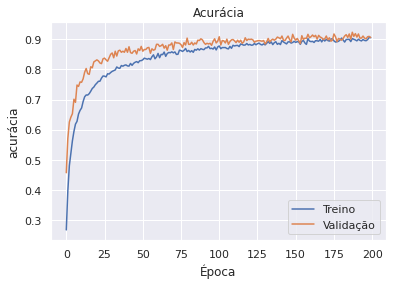

In [ ]:
#Plota esse dados da Acurácia
plt.plot(history.history['accuracy']) #treinamento
plt.plot(history.history['val_accuracy']) #validação
plt.title('Acurácia')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação']);

#### Visualiza os dados do Loss

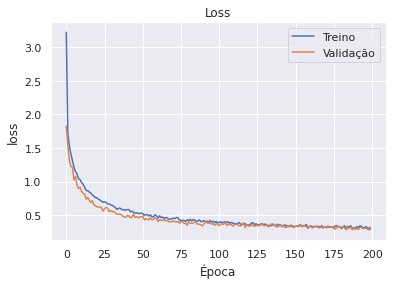

In [ ]:
#Plota esse dados do Loss
plt.plot(history.history['loss']) #treinamento
plt.plot(history.history['val_loss']) #validação
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação']);

In [ ]:
predicoes = modelo.predict(X_test)
predicoes, predicoes.shape
# a função softmax mostra as probalidades

28/28 [==============================] - 0s 2ms/step


(array([[2.0716885e-02, 7.8452456e-01, 2.9754085e-03, ..., 1.7451629e-01,
         1.4555850e-03, 2.7845270e-04],
        [4.3366645e-06, 2.1184727e-05, 3.7525999e-05, ..., 6.2827079e-04,
         2.4071222e-04, 6.1766738e-03],
        [3.6663036e-03, 1.2879883e-02, 1.4795029e-02, ..., 1.7248299e-02,
         1.0501492e-03, 3.7151622e-04],
        ...,
        [3.4432731e-05, 3.8677354e-06, 3.0244551e-06, ..., 6.4513029e-04,
         4.2975333e-04, 2.0935088e-04],
        [2.8526024e-03, 8.4055728e-01, 3.7425224e-04, ..., 1.3899352e-01,
         9.3123224e-04, 2.8491942e-03],
        [1.8942697e-02, 6.3783126e-03, 1.4922328e-03, ..., 3.9377943e-02,
         5.6656515e-03, 9.8885724e-04]], dtype=float32), (874, 10))

In [ ]:
#Para não mostrar os valores assim, recrio a variável predicoes e aplico a função argmax para mostrar os índices que correspondem à classificação (de 0 a 9 conforme o número de classes)
predicoes = predicoes.argmax(axis = 1)
predicoes

array([1, 4, 6, 4, 3, 1, 8, 3, 0, 6, 5, 1, 3, 1, 5, 8, 7, 5, 0, 3, 3, 7,
       0, 6, 0, 4, 6, 7, 3, 4, 6, 1, 4, 5, 6, 3, 0, 1, 2, 8, 1, 5, 8, 8,
       6, 3, 9, 8, 6, 7, 7, 8, 1, 5, 3, 2, 7, 8, 1, 7, 7, 3, 0, 7, 5, 6,
       9, 6, 5, 4, 8, 6, 3, 2, 5, 7, 8, 8, 5, 4, 1, 6, 1, 5, 8, 0, 3, 6,
       5, 0, 7, 6, 7, 3, 5, 5, 2, 8, 4, 0, 9, 7, 8, 8, 7, 3, 6, 3, 5, 3,
       1, 6, 0, 3, 8, 5, 5, 6, 8, 9, 4, 8, 4, 0, 6, 8, 7, 0, 1, 8, 5, 6,
       0, 5, 8, 1, 4, 6, 1, 0, 1, 7, 1, 5, 4, 5, 3, 8, 9, 4, 1, 5, 0, 1,
       1, 4, 4, 7, 4, 1, 3, 1, 5, 0, 6, 8, 8, 0, 6, 7, 7, 5, 5, 6, 3, 7,
       4, 3, 6, 4, 0, 4, 4, 4, 4, 8, 1, 7, 9, 1, 5, 7, 0, 3, 9, 7, 3, 8,
       6, 6, 4, 5, 6, 8, 7, 5, 0, 8, 5, 9, 1, 4, 7, 4, 0, 6, 5, 5, 0, 6,
       6, 0, 7, 4, 1, 2, 6, 5, 0, 8, 5, 5, 5, 9, 4, 4, 3, 1, 9, 1, 3, 0,
       4, 0, 3, 7, 1, 2, 7, 7, 6, 1, 1, 7, 8, 7, 5, 5, 8, 4, 7, 4, 4, 8,
       7, 4, 7, 1, 0, 5, 3, 3, 3, 3, 7, 3, 5, 8, 7, 7, 0, 0, 1, 0, 7, 4,
       7, 3, 7, 7, 7, 3, 1, 6, 1, 5, 6, 5, 2, 5, 3,

In [ ]:
# Classes pelo nome, fazendo a transformação inversa
predicoes = predicoes.astype(int).flatten()
predicoes = (labelencoder.inverse_transform((predicoes)))

df_predicoes = pd.DataFrame({'Classes previstas': predicoes})
df_predicoes

,Classes previstas
0,britadeira
1,latido_cachorro
2,musica_de_rua
3,latido_cachorro
4,crianca_brincando
...,...
869,britadeira
870,sirene
871,latido_cachorro
872,britadeira


In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Faz a reversão na transformação das classes para visualização  dos nomes

In [ ]:
# Faz a transformação inversa para mostrar o nome das classes reais
dfclasse_real = y_test.argmax(axis = 1)
dfclasse_real = dfclasse_real.astype(int).flatten()
dfclasse_real = labelencoder.inverse_transform(dfclasse_real)
dfclasse_real = pd.DataFrame({'Classes reais': dfclasse_real})
dfclasse_real

,Classes reais
0,britadeira
1,latido_cachorro
2,musica_de_rua
3,latido_cachorro
4,sirene
...,...
869,britadeira
870,sirene
871,latido_cachorro
872,britadeira


### Concatena os dois dataframes

In [ ]:
#Concatena os dois dataframes
final_df = dfclasse_real.join(df_predicoes)
final_df

,Classes reais,Classes previstas
0,britadeira,britadeira
1,latido_cachorro,latido_cachorro
2,musica_de_rua,musica_de_rua
3,latido_cachorro,latido_cachorro
4,sirene,crianca_brincando
...,...,...
869,britadeira,britadeira
870,sirene,sirene
871,latido_cachorro,latido_cachorro
872,britadeira,britadeira


In [ ]:
final_df[110:120]

,Classes reais,Classes previstas
110,britadeira,britadeira
111,crianca_brincando,musica_de_rua
112,ar_condicionado,ar_condicionado
113,crianca_brincando,crianca_brincando
114,sirene,sirene
115,motor_em_marcha_lenta,motor_em_marcha_lenta
116,latido_cachorro,motor_em_marcha_lenta
117,musica_de_rua,musica_de_rua
118,sirene,sirene
119,tiro_arma,tiro_arma


#### Matriz de confusão

Text(83.59374999999999, 0.5, 'Classes reais')

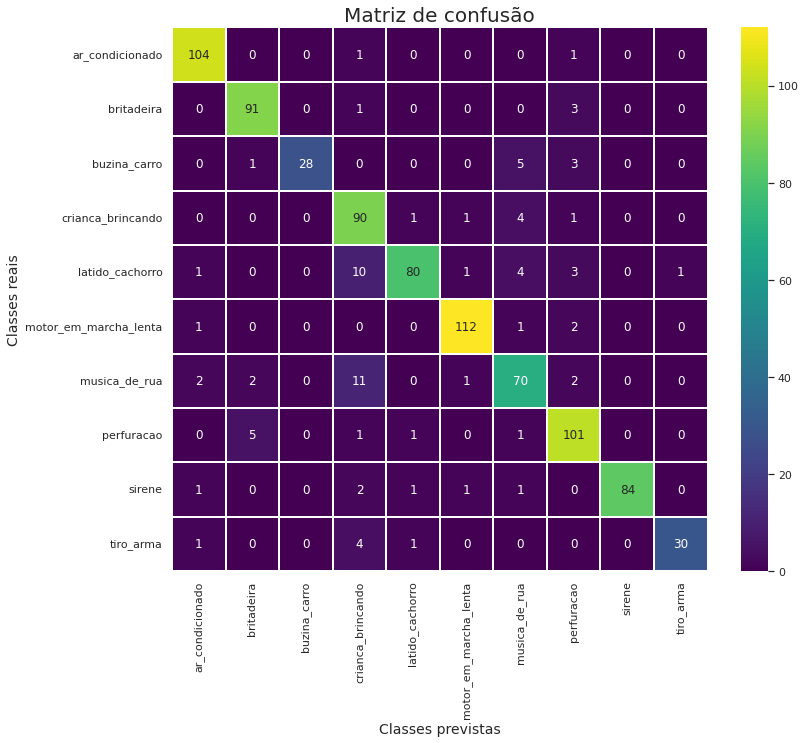

In [ ]:
#Matriz de confusão
cm = confusion_matrix(dfclasse_real, df_predicoes)
cm = pd.DataFrame(cm, index = [i for i in labelencoder.classes_], columns = [i for i in labelencoder.classes_])
plt.figure(figsize = (12,10))
ax = sns.heatmap(cm, linecolor = 'white', cmap = 'viridis', linewidth=1, annot = True, fmt = '') #Greys_r
bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de confusão', size = 20)
plt.xlabel('Classes previstas', size = 14)
plt.ylabel('Classes reais', size = 14)

#### A melhor classificação foi de sons de ar condicionado: o algoritmo consegue classificar corretamente 98% dos áudios de ar condicionado (recall) e quando ele classifica ele tem 95% de precisão.

In [ ]:
print(classification_report(dfclasse_real, df_predicoes))


                       precision    recall  f1-score   support

      ar_condicionado       0.95      0.98      0.96       106
           britadeira       0.92      0.96      0.94        95
         buzina_carro       1.00      0.76      0.86        37
    crianca_brincando       0.75      0.93      0.83        97
      latido_cachorro       0.95      0.80      0.87       100
motor_em_marcha_lenta       0.97      0.97      0.97       116
        musica_de_rua       0.81      0.80      0.80        88
           perfuracao       0.87      0.93      0.90       109
               sirene       1.00      0.93      0.97        90
            tiro_arma       0.97      0.83      0.90        36

             accuracy                           0.90       874
            macro avg       0.92      0.89      0.90       874
         weighted avg       0.91      0.90      0.90       874

